In [65]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
import nltk 
import re
from wordcloud import WordCloud
from PIL import Image
import time
import joblib
from sklearn.pipeline import Pipeline

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def load_data(path):
  '''
  Returns the data to be modelled. 
  Arg: Path to the data directory
  '''
  return pd.read_csv(path)
mock_reviews = load_data("/content/MockComplains_Labelled.csv")

In [19]:
def load_stopwords(stopwords_file):
  with open(stopwords_file, "r", encoding="utf-8") as f:
    stopwords = f.readlines()
    stop_set = set(m.strip() for m in stopwords)
    return list(frozenset(stop_set))

In [ ]:
mock_reviews.head(2)

,Prompt,Issue
0,"1. ""I've been experiencing inconsistent fuel d...",Fuel Pressure Regulator
1,"2. ""There's a lack of power and hesitation whe...",Fuel Pressure Regulator


In [32]:
#basic cleaning of the data
def clean_prompts(prompts):
  prompts = prompts.str.replace('\d+', '')
  prompts = prompts.str.replace(".", "")
  prompts = prompts.str.replace('"', "")
  prompts = prompts.str.replace("'", "")
  prompts = prompts.str.lower()
  return prompts
mock_reviews['cleanPrompt'] = clean_prompts(mock_reviews['Prompt']) 
mock_reviews.head(2)

<ipython-input-32-02897c36af2b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  prompts = prompts.str.replace('\d+', '')
<ipython-input-32-02897c36af2b>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  prompts = prompts.str.replace(".", "")


,Prompt,Issue,cleanPrompt
0,"1. ""I've been experiencing inconsistent fuel d...",Fuel Pressure Regulator,ive been experiencing inconsistent fuel deliv...
1,"2. ""There's a lack of power and hesitation whe...",Fuel Pressure Regulator,theres a lack of power and hesitation when ac...


# EXPLORATORY DATA ANALYSIS
## Class Distribution. 

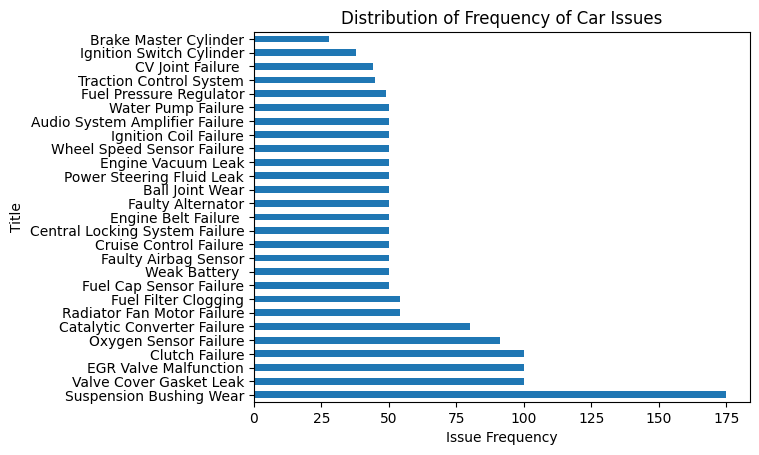

In [33]:
def get_issue_distribution(data):
  data.Issue.value_counts().plot(kind="barh")
  plt.xlabel("Issue Frequency")
  plt.ylabel("Title")
  plt.title("Distribution of Frequency of Car Issues")
  plt.show()
get_issue_distribution(mock_reviews)

##Common Keywords Used

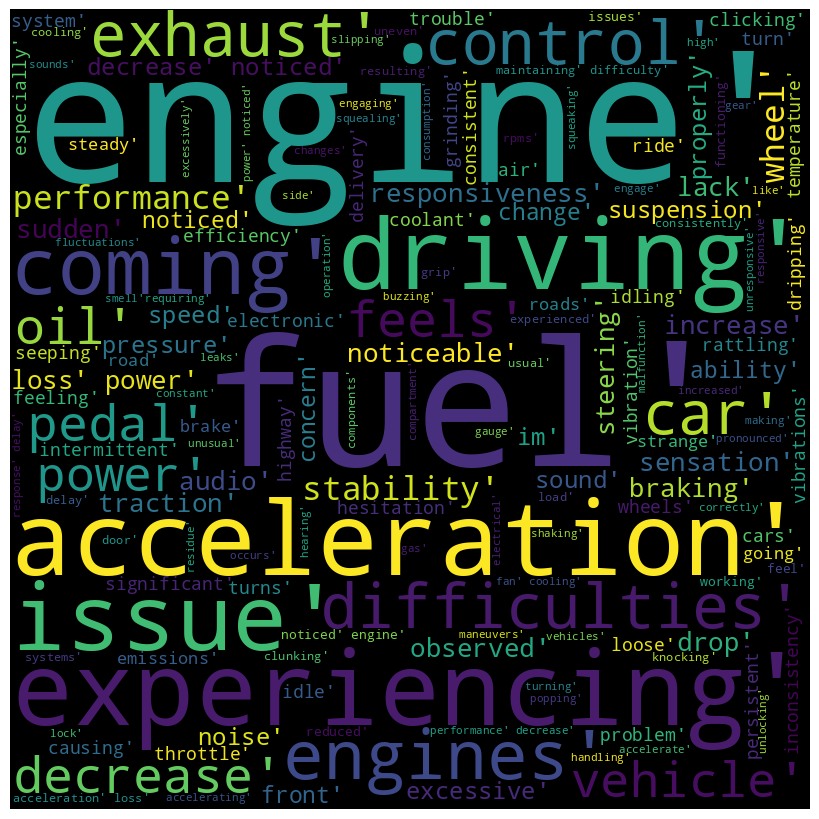

In [35]:
stopwords = load_stopwords("/content/stopwords.txt")
customer_prompts = mock_reviews.cleanPrompt.to_list()
def sort_coo(coo_matrix):
  #sort dictionary with highest score
  tuples = zip(coo_matrix.col, coo_matrix.data) 
  return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
#getting feature names and tf-idf score of top n items in the corpus
def extract_top_items(feature_names, sorted_items, topn=10):
  sorted_items = sorted_items[:topn]
  score_vals = []
  feature_vals = []

  for idx, score in sorted_items:
    score_vals.append(round(score, 3))
    feature_vals.append(feature_names[idx])
  #creating a tuple of feature and score
  results = {}
  for idx in range(len(feature_vals)):
    results[feature_vals[idx]] = score_vals[idx]
  return results 
#returning keywords using tfidf method
def get_keywords(vectorizer, feature_names, doc):
  #returns top n keywords from a document/review using TF-IDF Method. 
  tfidf_vector = vectorizer.transform([doc])
  #sorting the tf vectors by descending order of scores
  sorted_items = sort_coo(tfidf_vector.tocoo())
  #extracting top_n keywords
  keywords = extract_top_items(feature_names, sorted_items, 5)
  return list(keywords.keys())
tfVect = TfidfVectorizer(stop_words = stopwords, smooth_idf=True, use_idf=True) 
tfVect.fit_transform(customer_prompts)
#storing the vocab 
feature_names = tfVect.get_feature_names_out()
all_keywords = []
for doc in customer_prompts:
  keywords = get_keywords(tfVect, feature_names, doc)
  all_keywords.append(keywords)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(str(all_keywords))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


# EXPERIMENTATION

In [39]:
def remove_stopwords(data):
  data['cleanPrompts'] = data['cleanPrompt'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data
mock_reviews = remove_stopwords(mock_reviews)

In [48]:
def data_preparation(range):
  X_train, X_test, y_train, y_test = train_test_split(mock_reviews['cleanPrompts'], mock_reviews['Issue'], test_size=0.3, 
                                                      random_state=41)
  cv = CountVectorizer(ngram_range=range, analyzer="word")
  tfidf = TfidfVectorizer(ngram_range=range, analyzer="word")
  X_train_cv = cv.fit_transform(X_train)
  X_train_tfidf = tfidf.fit_transform(X_train)
  X_test_cv, X_test_tfidf = cv.transform(X_test), tfidf.transform(X_test)
  return X_train_cv.toarray(), X_train_tfidf.toarray(), X_test_cv.toarray(), X_test_tfidf.toarray(), y_train, y_test 

In [49]:
X_train_cv_unigram, X_train_tfidf_unigram, X_test_cv_unigram, X_test_tfidf_unigram, y_train, y_test = data_preparation((1,1))
X_train_cv_bigram, X_train_tfidf_bigram, X_test_cv_bigram, X_test_tfidf_bigram, y_train, y_test = data_preparation((1,2))
X_train_cv_trigram, X_train_tfidf_trigram, X_test_cv_trigram, X_test_tfidf_trigram, y_train, y_test = data_preparation((1,3))


In [50]:
models = [SGDClassifier(), LogisticRegression(), DecisionTreeClassifier(), 
          RandomForestClassifier(), MultinomialNB(), GaussianNB()]
def fit_clf(x_train, x_test, y_train, y_test):
  accs, precs, recs, f1s, pred_lats = [], [], [], [], []
  for clf in models:
    clf.fit(x_train, y_train)
    start_time = time.process_time()
    preds = clf.predict(x_test)
    pred_lat = time.process_time() - start_time
    acc = accuracy_score(preds, y_test)
    prec = precision_score(preds, y_test, average="weighted")
    rec = recall_score(preds, y_test, average="weighted")
    f1 = f1_score(preds, y_test, average="weighted")
    accs.append(acc), precs.append(prec), recs.append(rec), f1s.append(f1), pred_lats.append(pred_lat)
  return accs, precs, recs, f1s, pred_lats


In [51]:
def tabulate_results(accs, precs, recs, f1s, pred_lats):
  exp_df = pd.DataFrame(columns=["Model", "Acc", "PrecScore", "RecScore", 
                                 "F1Score", "PredictionLatency"])
  clfs = ["SGDClf", "LogReg", "Dtree", "RandomForest", "Mnb", "GnB"]
  exp_df['Model'] = clfs
  exp_df['Acc'] = accs
  exp_df['PrecScore'] = precs
  exp_df['RecScore'] = recs 
  exp_df['F1Score'] = f1s
  exp_df['PredictionLatency'] = pred_lats 
  return exp_df 


## Feature+Model Experimentation
### CV Results

In [52]:

unigram_cv_acc, unigram_cv_prec, unigram_cv_rec, unigram_cv_f1, unigram_cv_predlat = fit_clf(X_train_cv_unigram, 
                                                                                             X_test_cv_unigram, 
                                                                                             y_train, y_test)
unigram_cv_results = tabulate_results(unigram_cv_acc, unigram_cv_prec, unigram_cv_rec, unigram_cv_f1, unigram_cv_predlat )
unigram_cv_results

,Model,Acc,PrecScore,RecScore,F1Score,PredictionLatency
0,SGDClf,0.644578,0.679310,0.644578,0.647767,0.012465
1,LogReg,0.704819,0.735876,0.704819,0.712244,0.014931
2,Dtree,0.628514,0.664285,0.628514,0.635667,0.002637
3,RandomForest,0.686747,0.753932,0.686747,0.704248,0.051900
4,Mnb,0.630522,0.751637,0.630522,0.665384,0.007374
5,GnB,0.610442,0.620110,0.610442,0.605844,0.185499


In [53]:
bigram_cv_acc, bigram_cv_prec, bigram_cv_rec, bigram_cv_f1, bigram_cv_predlat = fit_clf(X_train_cv_bigram, 
                                                                                             X_test_cv_bigram, 
                                                                                             y_train, y_test)
bigram_cv_results = tabulate_results(bigram_cv_acc, bigram_cv_prec, bigram_cv_rec, bigram_cv_f1, bigram_cv_predlat)
bigram_cv_results

,Model,Acc,PrecScore,RecScore,F1Score,PredictionLatency
0,SGDClf,0.636546,0.654030,0.636546,0.628741,0.039031
1,LogReg,0.700803,0.734159,0.700803,0.707041,0.061049
2,Dtree,0.634538,0.673485,0.634538,0.641014,0.007463
3,RandomForest,0.664659,0.737412,0.664659,0.679157,0.070047
4,Mnb,0.672691,0.757118,0.672691,0.693886,0.022908
5,GnB,0.668675,0.684471,0.668675,0.670631,0.476165


In [54]:
trigram_cv_acc, trigram_cv_prec, trigram_cv_rec, trigram_cv_f1, trigram_cv_predlat = fit_clf(X_train_cv_trigram, 
                                                                                             X_test_cv_trigram, 
                                                                                             y_train, y_test)
trigram_cv_results = tabulate_results(trigram_cv_acc, trigram_cv_prec, trigram_cv_rec, trigram_cv_f1, trigram_cv_predlat)
trigram_cv_results

,Model,Acc,PrecScore,RecScore,F1Score,PredictionLatency
0,SGDClf,0.648594,0.691471,0.648594,0.650748,0.047909
1,LogReg,0.696787,0.737693,0.696787,0.703044,0.103274
2,Dtree,0.634538,0.662704,0.634538,0.638383,0.009448
3,RandomForest,0.646586,0.703340,0.646586,0.658679,0.126559
4,Mnb,0.676707,0.757013,0.676707,0.698190,0.048591
5,GnB,0.686747,0.697912,0.686747,0.687054,1.320975


### TFIDF Results

In [55]:
unigram_tfidf_acc, unigram_tfidf_prec, unigram_tfidf_rec, unigram_tfidf_f1, unigram_tfidf_predlat = fit_clf(X_train_tfidf_unigram, 
                                                                                             X_test_tfidf_unigram, 
                                                                                             y_train, y_test)
unigram_tfidf_results = tabulate_results(unigram_tfidf_acc, unigram_tfidf_prec, unigram_tfidf_rec, unigram_tfidf_f1, unigram_tfidf_predlat)
unigram_tfidf_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Acc,PrecScore,RecScore,F1Score,PredictionLatency
0,SGDClf,0.670683,0.688619,0.670683,0.673865,0.006796
1,LogReg,0.620482,0.738426,0.620482,0.647884,0.012797
2,Dtree,0.602410,0.623119,0.602410,0.604447,0.002562
3,RandomForest,0.708835,0.756395,0.708835,0.721740,0.047340
4,Mnb,0.483936,0.797186,0.483936,0.545201,0.011514
5,GnB,0.572289,0.581727,0.572289,0.568447,0.095615


In [56]:
bigram_tfidf_acc, bigram_tfidf_prec, bigram_tfidf_rec, bigram_tfidf_f1, bigram_tfidf_predlat = fit_clf(X_train_tfidf_bigram, 
                                                                                             X_test_tfidf_bigram, 
                                                                                             y_train, y_test)
bigram_tfidf_results = tabulate_results(bigram_tfidf_acc, bigram_tfidf_prec, bigram_tfidf_rec, bigram_tfidf_f1, bigram_tfidf_predlat)
bigram_tfidf_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Acc,PrecScore,RecScore,F1Score,PredictionLatency
0,SGDClf,0.684739,0.704805,0.684739,0.682322,0.039118
1,LogReg,0.606426,0.771803,0.606426,0.634977,0.036508
2,Dtree,0.584337,0.634628,0.584337,0.589024,0.006458
3,RandomForest,0.672691,0.735867,0.672691,0.685003,0.088205
4,Mnb,0.485944,0.819802,0.485944,0.526730,0.021281
5,GnB,0.646586,0.665386,0.646586,0.649312,0.432106


In [57]:
trigram_tfidf_acc, trigram_tfidf_prec, trigram_tfidf_rec, trigram_tfidf_f1, bigram_tfidf_predlat = fit_clf(X_train_tfidf_trigram, 
                                                                                             X_test_tfidf_trigram, 
                                                                                             y_train, y_test)
trigram_tfidf_results = tabulate_results(trigram_tfidf_acc, trigram_tfidf_prec, trigram_tfidf_rec, trigram_tfidf_f1, bigram_tfidf_predlat)
trigram_tfidf_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Acc,PrecScore,RecScore,F1Score,PredictionLatency
0,SGDClf,0.694779,0.747555,0.694779,0.710417,0.041236
1,LogReg,0.594378,0.793311,0.594378,0.622260,0.062706
2,Dtree,0.528112,0.591974,0.528112,0.536640,0.007191
3,RandomForest,0.642570,0.720814,0.642570,0.657250,0.068152
4,Mnb,0.461847,0.830457,0.461847,0.494803,0.044202
5,GnB,0.668675,0.679115,0.668675,0.669016,0.985682


###  **Best Model Combination**
TFIDF Text vectorizer + Unigrams + Random Forest Classifier


### HyperParameter Optimization

In [59]:
#Defining the search space for RF
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8, 10], 'bootstrap': [True, False]}


In [60]:
#Initiating Random search space
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_tfidf_unigram, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 31, 52, 73, 94,
                                                         115, 136, 157, 178,
                                                         200]},
                   random_state=42, verbose=2)

In [61]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [63]:
best_rf_clf = rf_random.best_estimator_
rf_preds = best_rf_clf.predict(X_test_tfidf_unigram)
f1_score = f1_score(rf_preds, y_test, average="weighted")
acc_score = accuracy_score(rf_preds, y_test)
print("Optimized RF Performance")
print("<------------------------->")
print("F1 Score: " +str(f1_score))
print("Acc. Score: " +str(acc_score))

Optimized RF Performance
<------------------------->
F1 Score: 0.7217941894840658
Acc. Score: 0.714859437751004


# Exporting Classification Pipeline as Joblib Model

In [66]:
car_pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range=(1,1), analyzer="word")), 
                         ("clf", best_rf_clf)])
X_train, X_test, y_train, y_test = train_test_split(mock_reviews['cleanPrompts'], mock_reviews['Issue'], 
                                                    test_size=0.3, random_state=42)
car_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(bootstrap=False, max_depth=90,
                                        n_estimators=200))])

In [67]:
out_model = "carDiagnosticPipeline.sav"
joblib.dump(car_pipeline, out_model)

['carDiagnosticPipeline.sav']